adamW
convolution
residual
bath normalization, dropout
data augmentation
    elastic deform
    gaussian noise
    rotation
    crop
    dynamic zoom
    blur
    가리기
    3d rotation
    +여러가지 mnist data
    
learning late sceduling#to learn


구조
    eval() mod 일 때에는 기존 convolutional network+positional embedding 처럼 동작.
    즉, 4채널짜리 Convolution이 되는 것.
    그러나 train mod 일 때에는, 사진이라고 하는 데이터의 특성을 극한으로 활용
    Pre-augmented dataset(digit-five 등등

구조 자세히
    

In [1]:
#data 관련 임포트
import torch
import numpy as np
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision import transforms
from scipy import io

In [2]:
#모델 임포트
import torch
import torch.nn as nn

#유틸 임포트
import pprint
from os.path import exists
from matplotlib import pyplot as plt
import numpy as np

In [3]:
PATH_FOLDER = '../datasets/DIGIT_FIVE/'
files = ['mnistm_with_label.mat','svhn_train_32x32.mat','syn_number.mat','usps_28x28.mat']

In [4]:
class mnistAm(Dataset):
    def __init__(self, train = True):
        #transforms.Compose([transforms.ToTensor(),lambda x: x.repeat(1,3,1,1), lambda x: torch.mul(x,torch.rand(3,28,28))])
        self.train = train
        
        mat_file = io.loadmat(PATH_FOLDER+files[3])
        if self.train == True:
            mnist = datasets.MNIST('./datasets',train=True , download = True)
            data1 = mnist.train_data.unsqueeze(1)
            data2 = torch.tensor(mat_file['dataset'][0][0],dtype=torch.float32)*255
            self.data = torch.cat((data1, data2), dim=0)
            label1 = mnist.train_labels
            label2 = torch.tensor(mat_file['dataset'][0][1].reshape(-1))#vector
            self.label = torch.cat((label1, label2), dim=0)
        else:
            mnist = datasets.MNIST('./datasets',train=False , download = True)
            data1 = mnist.test_data.unsqueeze(1)
            data2 = torch.tensor(mat_file['dataset'][1][0],dtype=torch.float32)*255
            self.data = torch.cat((data1, data2), dim=0)
            label1 = mnist.test_labels
            label2 = torch.tensor(mat_file['dataset'][1][1].reshape(-1))#vector
            self.label = torch.cat((label1, label2), dim=0)
        self.data = self.data.repeat(1,3,1,1)/255
        self.rtransform = transforms.RandomApply(transforms = [lambda x: torch.mul(x,torch.rand(3,28,28))], p=1)
    def __len__(self):
        return len(self.data)
    def __getitem__(self, index):
        return self.rtransform(self.data[index]) , self.label[index]

In [5]:
class mnistm(Dataset):
    def __init__(self, train = True):
        self.train = train
        mat_file = io.loadmat(PATH_FOLDER+files[0])
        if self.train == True:
            self.data = torch.tensor(mat_file['train'].transpose(0,3,1,2)/255,dtype=torch.float32)
            self.label = torch.tensor(mat_file['label_train'].argmax(axis = 1))
        else:
            self.data = torch.tensor(mat_file['test'].transpose(0,3,1,2)/255,dtype=torch.float32)
            self.label = torch.tensor(mat_file['label_test'].argmax(axis = 1))
    def __len__(self):
        return len(self.data)
    def __getitem__(self, index):
        return self.data[index], self.label[index]

In [6]:
class svhn(Dataset):
    def __init__(self, train = True):
        tn = 60000#max:73257
        self.train = train
        mat_file = io.loadmat(PATH_FOLDER+files[1])
        if self.train == True:
            self.data = torch.tensor(mat_file['X'].transpose(3,2,0,1)[:tn]/255,dtype=torch.float32)
            self.label = torch.tensor(mat_file['y'][:tn].reshape(-1)-1)
        else:
            self.data = torch.tensor(mat_file['X'].transpose(3,2,0,1)[tn:]/255,dtype=torch.float32)
            self.label = torch.tensor(mat_file['y'][tn:].reshape(-1)-1)
        resize = transforms.Resize((28,28))
        self.data = resize(self.data)
    def __len__(self):
        return len(self.data)
    def __getitem__(self, index):
        return self.data[index], self.label[index]

In [7]:
class svn(Dataset):
    def __init__(self, train = True):
        self.train = train
        mat_file = io.loadmat(PATH_FOLDER+files[2])
        if self.train == True:
            self.data = torch.tensor(mat_file['train_data'].transpose(0,3,1,2)/255,dtype=torch.float32)
            self.label = torch.tensor(mat_file['train_label'].reshape(-1))
        else:
            self.data = torch.tensor(mat_file['test_data'].transpose(0,3,1,2)/255,dtype=torch.float32)
            self.label = torch.tensor(mat_file['test_label'].reshape(-1))
        resize = transforms.Resize((28,28))
        self.data = resize(self.data)
    def __len__(self):
        return len(self.data)
    def __getitem__(self, index):
        return self.data[index], self.label[index]

In [8]:
class comdata(Dataset):
    def __init__(self, train = True):
        self.datasets = [
            mnistAm(train=train),
            mnistm(train=train),
            svhn(train=train),
            svn(train=train)
        ]
        self.lengthsegment = []
        for dataset in self.datasets:
            if len(self.lengthsegment) == 0:
                last_len = 0
            else:
                last_len = self.lengthsegment[-1]
            self.lengthsegment.append(len(dataset)+last_len)
        self.lengthsegment = torch.tensor(self.lengthsegment)
    def __len__(self):
        return self.lengthsegment[-1]
    def __getitem__(self, index):
        cansize = self.lengthsegment[self.lengthsegment >= index+1][0]
        canindex = (self.lengthsegment == cansize).int().argmax()
        return self.datasets[canindex][-(cansize-(index+1)+1)]
        
        

In [9]:
#사진 뒤집고, 노이즈 적용하고,회전시키고, random perspective.
t_noise = transforms.Compose([lambda x: x+torch.randn(x.size()).to(device=device)*np.random.randint(5)*0.01, lambda x: torch.clamp(x, min=0, max=1) ])
ut = transforms.Compose([
    transforms.RandomInvert(),
    t_noise,
    transforms.RandomRotation(degrees = (-90,90)),
    transforms.RandomPerspective(distortion_scale=0.3, p = 0.5)
])


In [10]:
"""
tdf = comdata(train=False)



t = torch.tensor([-2,3,1])

torch.clamp(t,min=-1)

t_noise = transforms.Compose([lambda x: x+torch.randn(x.size())*np.random.randint(5)*0.01, lambda x: torch.clamp(x, min=0, max=1) ])
ut = transforms.Compose([
    transforms.RandomInvert(),
    t_noise,
    transforms.RandomRotation(degrees = (-90,90)),
    transforms.RandomPerspective(distortion_scale=0.3, p = 0.5)
])

n = 23043
plt.imshow(ut(tdf[n][0]).permute(1,2,0))
"""

'\ntdf = comdata(train=False)\n\n\n\nt = torch.tensor([-2,3,1])\n\ntorch.clamp(t,min=-1)\n\nt_noise = transforms.Compose([lambda x: x+torch.randn(x.size())*np.random.randint(5)*0.01, lambda x: torch.clamp(x, min=0, max=1) ])\nut = transforms.Compose([\n    transforms.RandomInvert(),\n    t_noise,\n    transforms.RandomRotation(degrees = (-90,90)),\n    transforms.RandomPerspective(distortion_scale=0.3, p = 0.5)\n])\n\nn = 23043\nplt.imshow(ut(tdf[n][0]).permute(1,2,0))\n'

In [11]:
def GPUreport():
    if torch.cuda.is_available():
        for i in range(torch.cuda.device_count()):
            print(f"# DEVICE {i}: {torch.cuda.get_device_name(i)}")
            print("- Memory Usage:")
            print(f"  Allocated: {round(torch.cuda.memory_allocated(i)/1024**3,1)} GB")
            print(f"  Cached:    {round(torch.cuda.memory_cached(i)/1024**3,1)} GB\n")
    else:
        print("# GPU is not available")
GPUreport()

# DEVICE 0: NVIDIA GeForce RTX 3090
- Memory Usage:
  Allocated: 0.0 GB
  Cached:    0.0 GB

# DEVICE 1: NVIDIA GeForce RTX 3090
- Memory Usage:
  Allocated: 0.0 GB
  Cached:    0.0 GB



/opt/conda/envs/Conda1/lib/python3.9/site-packages/torch/cuda/memory.py:384: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  warnings.warn(


In [12]:
GPU_NUM = 1#

device = (torch.device(f'cuda:{GPU_NUM}') if torch.cuda.is_available() else torch.device('cpu'))
torch.cuda.set_device(device)
#device = torch.device('cpu')#cpu

print("Current Device is: ", device)

Current Device is:  cuda:1


In [13]:
def conv1x1(in_cha, out_cha, stride = 1):
    #downsampling 할때 쓰는 conv
    return nn.Conv2d(in_cha, out_cha, kernel_size=1, stride=stride, bias=False).to(device = device)

class res_block(nn.Module):#shortcut 없는 그냥 Block
    #positional_dimension = 3
    def __init__(self, dropp, out_cha, stride=1, dilation=1):# Input channel 에 adaptive 하게 작동.
        self.outlist = []#debug
        self.pd = 6 #positional_dimension
        super(res_block, self).__init__()
        self.param_dict = nn.ParameterDict()
        self.hyper = {'out_cha':out_cha, 'stride':stride, 'dilation':dilation}
        self.downsample = None
        self.relu = nn.ReLU()
        
        self.posi1 = None#positional embedding
        self.conv1 = None
        self.dropout1 = nn.Dropout(dropp)
        self.bn1 = nn.BatchNorm2d(out_cha).to(device = device)
        
        self.posi2 = None#positional embedding
        self.conv2 = nn.Conv2d(self.hyper['out_cha']+self.pd , self.hyper['out_cha'], kernel_size = 3, stride = 1, padding = self.hyper['dilation'], dilation=self.hyper['dilation']).to(device = device)
        self.dropout2 = nn.Dropout(dropp)
        self.bn2 = nn.BatchNorm2d(out_cha).to(device = device)
    def backup(self, tensor):
        self.outlist.append(tensor)
    def clearbackup(self):
        self.outlist = []
    def forward(self, x):#x=N,C,H,W
        identity = x
        batch_size = x.shape[0]
        if self.posi1 is None:
            square_h_1 = x.shape[2]#Input 사진이 정사각형임을 가정.
            self.posi1 = nn.Parameter(torch.randn(self.pd, square_h_1, square_h_1).unsqueeze(0).to(device = device), requires_grad = True)
            #self.param_dict["posi_embed1"] = self.posi1
            #self.posi1 = self.posi1.to(device = device)
        duplicated_1 = self.posi1.repeat(batch_size,1,1,1)#입력의 batch size만큼 반복
        out = torch.cat((x,duplicated_1), dim = 1)
        if self.conv1 is None:
            self.conv1 = nn.Conv2d(x.shape[1]+self.pd , self.hyper['out_cha'], kernel_size = 3, stride = self.hyper['stride'], padding=self.hyper['dilation'], dilation=self.hyper['dilation']).to(device = device)
            
        out = self.conv1(out)
        #self.backup(out)
        out = self.dropout1(out)
        out = self.bn1(out)
        #self.backup(out)
        out = self.relu(out)
        #self.backup(out)
        #layer 2
        if self.posi2 is None:
            if self.hyper['stride'] == 1:
                self.posi2 = self.posi1#input-output shape를 그대로 쓰면 됨
            else:
                square_h_2 = out.shape[2]
                self.posi2 = nn.Parameter(torch.randn(self.pd,square_h_2, square_h_2).unsqueeze(0).to(device = device), requires_grad = True)
            #self.param_dict["posi_embed2"] = self.posi2
            #self.posi2 = self.posi2.to(device = device)
        duplicated_2 = self.posi2.repeat(batch_size,1,1,1)
        out = torch.cat((out,duplicated_2), dim = 1)
        out = self.conv2(out)
        out = self.dropout2(out)
        out = self.bn2(out)

        if self.downsample == None:
            if self.hyper['stride'] > 1 or x.shape[1] != out.shape[1]: #downsample 이거나 또는 channel size가 일치하지 않을 시
                self.downsample = conv1x1(identity.shape[1], self.hyper['out_cha'], stride = self.hyper['stride'])
        if self.downsample is not None:
            identity = self.downsample(x)
        
        out = out + identity
        out = self.relu(out)
        return out



In [14]:
class adaptiveLinear(nn.Module):
    def __init__(self,output_size):
        super(adaptiveLinear, self).__init__()
        self.output_size = output_size
        self.linear = None
    def forward(self,x):#x:batch size ~~blabla
        data = x.view(x.shape[0], -1)
        if self.linear is None:
            self.linear = nn.Linear(data.shape[1],self.output_size).to(device = device)
            #self.generated = None
        return self.linear(data)

In [15]:
class posiresNN(nn.Module):
    def __init__(self):
        super(posiresNN, self).__init__()
        self.modelname = "posires"
        self.residual = nn.Sequential(
            res_block(0, 64),
            res_block(0, 64),
            res_block(0, 64),
            res_block(0, 64),
            res_block(0, 64),
            res_block(0, 128, stride=2),#14*14
            res_block(0, 128),
            adaptiveLinear(10))
    def forward(self, x):
        return self.residual(x)

In [16]:
def training_loop(optimizer, model, loss_fn, train_loader, test_loader, epochs, train_loss_list, val_loss_list, accuracy_list):
    AGUMENT = 1
    for epoch in range(1,epochs+1):
        model.train()
        loss_train = 0.0
        #model specific code
        if epoch == 1:
            print('epoch 1')
            previous = model.residual[0].posi1[0][0].detach().to(device='cpu').numpy()
        current = model.residual[0].posi1[0][0].detach().to(device='cpu').numpy()
        plt.imshow(current-previous, cmap='gray')
        plt.show()
        previous = model.residual[0].posi1[0][0].detach().to(device='cpu').numpy()
        #model specific code
        batchiter = 0#batchiter: 배치의 개수. batchiter*batch_size 해야 대략적인 총 데이터 개수.
        for images, labels, in train_loader:
            labels = labels.to(device=device)
            outputs = None
            labels_a = None
            for i in range(AGUMENT):
                images_a = ut(images.to(device=device))
                if outputs is not None:
                    outputs = torch.cat((outputs, model(images_a)),dim=0)#batchsize*10
                    labels_a = torch.cat((labels_a,labels),dim=0)
                else:
                    outputs = model(images_a)
                    labels_a = labels
            loss = loss_fn(outputs, labels_a)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_train += loss.item()
        loss_train = loss_train/len(train_loader)
        loss_validation, accuracy = evaluate_model(model, test_loader, loss_fn)
        train_loss_list += [loss_train]
        val_loss_list += [loss_validation]
        accuracy_list += [accuracy]
        torch.save(model.state_dict(), model.modelname+'.pt')#debug
        print("epoch:",epoch, " train_loss: ", loss_train, " val_loss: ", loss_validation, " val_accuracy: ", accuracy)
        

        
def evaluate_model(model, data_loader, loss_fn):
    model.eval()
    total_size = 0
    loss_test = 0.0
    accuracy = 0
    with torch.no_grad():
        for images, labels, in data_loader:
            images = images.to(device=device)#batchsize*1*28*28
            labels = labels.to(device=device)#batchsize
            outputs = model(images)#batchsize*10
            output_labels = outputs.argmax(dim=1)
            accuracy += torch.sum(output_labels == labels).item()
            total_size += len(labels)
            loss = loss_fn(outputs, labels)
            loss_test += loss.item()
    loss_test = loss_test/len(data_loader)
    accuracy = accuracy/total_size
    model.train()
    return loss_test, accuracy


In [17]:
BATCHSIZE_TRAIN = 2000
DROPOUT_PERCENT = 0
LR = 4e-3
EPOCHES = 0
train_loader = DataLoader(comdata(train=True), batch_size = BATCHSIZE_TRAIN, shuffle = True) #20만개 넘음
test_loader = DataLoader(comdata(train=False), batch_size = 2000, shuffle =True) #7만개?
loss_fn = nn.CrossEntropyLoss()

/opt/conda/envs/Conda1/lib/python3.9/site-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/opt/conda/envs/Conda1/lib/python3.9/site-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/opt/conda/envs/Conda1/lib/python3.9/site-packages/torchvision/datasets/mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/opt/conda/envs/Conda1/lib/python3.9/site-packages/torchvision/datasets/mnist.py:70: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


posiresNN(
  (residual): Sequential(
    (0): res_block(
      (param_dict): ParameterDict()
      (relu): ReLU()
      (dropout1): Dropout(p=0, inplace=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(70, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (dropout2): Dropout(p=0, inplace=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): res_block(
      (param_dict): ParameterDict()
      (relu): ReLU()
      (dropout1): Dropout(p=0, inplace=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(70, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (dropout2): Dropout(p=0, inplace=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): res_block(
      (param_dict): ParameterDict()
      (relu): ReLU()
  

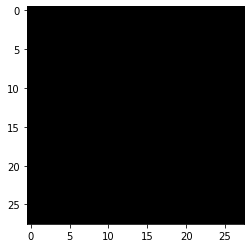

epoch: 1  train_loss:  0.1840391788774958  val_loss:  0.253755219604658  val_accuracy:  0.9205748350975814


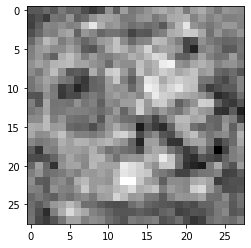

epoch: 2  train_loss:  0.17193622715198076  val_loss:  0.4968288787033247  val_accuracy:  0.8382482943083165


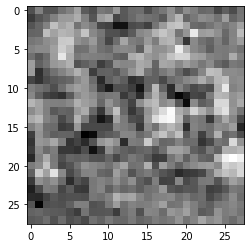

KeyboardInterrupt: 

In [18]:
model = posiresNN()
print(model)
filename_parameters = model.modelname+'.pt'
dummy_tensor = torch.rand((1,3,28,28), requires_grad = False).to(device = device)
model(dummy_tensor)
if exists(filename_parameters):
    print(filename_parameters, "exists.")

    model.load_state_dict(torch.load("./" + filename_parameters))
else:
    print(filename_parameters, "does not exists.")
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay = 0.004)
train_loss_list =[]
val_loss_list = []
accuracy_list = []
training_loop(optimizer, model, loss_fn, train_loader, test_loader, EPOCHES, train_loss_list, val_loss_list, accuracy_list)

In [ ]:

print(evaluate_model(model, test_loader, loss_fn))

In [ ]:
sample = None
for items in train_loader:
    sample = items
    break

In [ ]:
sample[0][4].shape

In [ ]:
model

In [ ]:
num =1430
sample_image = ut(sample[0][num].unsqueeze(0)).squeeze(0)
plt.imshow(sample_image.permute(1,2,0))

In [ ]:
layer = 6
model.residual[layer].clearbackup()
print(model(sample_image.unsqueeze(0)))
insight = model.residual[layer].outlist

In [ ]:
insight[0].permute(0,2,3,1).shape

In [ ]:
def detach(tensor):
    return tensor.to(device='cpu').detach().numpy()

In [ ]:
for image in insight[2][0]:
    plt.imshow(detach(image),cmap='gray')
    plt.show()
    

In [ ]:
plt.imshow(p1[0][2].to(device='cpu').detach().numpy(), cmap='gray')